In [1]:
import mlflow
import mlflow.spacy
import mlflow.sklearn
import polars as pl
import seaborn as sns
import scipy
import duckdb
import numpy as np
import json
import timeit
import matplotlib.pyplot as plt
from rank_bm25 import BM25Okapi

In [2]:
import os
import sys
from dotenv import load_dotenv
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))
from app.model_functions import run_BOW_on_line
from app.evaluation import reciprocal_rank, rank_BOW_results, precision_at_k
from app.data_handling.BOW import transform_ds_to_BOW
from app.data_handling.NER_parquet import (
process_ingredient,
transform_ingredients_to_tokens,
transform_data_to_tokens,
construct_ingredient_query,
ParquetDefinition,
create_parquet_file
)

load_dotenv()

True

In [3]:
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URL"))

In [4]:
with open("../../data/eval_data/processed_data.json", "r") as f:
    query_ds = pl.read_json(f)

In [5]:
with open("../../data/eval_data/human_annotations.json", "r") as f:
    human_query_ds = pl.read_json(f)

In [6]:
with open("../../data/eval_data/eval_10k.json", "r") as f:
    eval_ds = pl.read_json(f)

In [7]:
eval_ds = query_ds

### Sanitycheck that query_ds is a subset of eval_ds

In [8]:
query_idx = query_ds['index']
eval_ds.select('index').filter(pl.col('index').is_in(query_idx)).shape[0] == query_ds.shape[0]

/tmp/ipykernel_3793673/3215214846.py:2: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  eval_ds.select('index').filter(pl.col('index').is_in(query_idx)).shape[0] == query_ds.shape[0]


True

In [9]:
model_uri = 'models:/recipe_BOW@prod'
BOW_model = mlflow.sklearn.load_model(model_uri)

In [10]:
results_df = pl.DataFrame(
    schema={
        'Model': pl.String,
        'Eval_Task': pl.String,
        "MRR": pl.Float64,
        "P@3": pl.Float64,
        "Time_Tot": pl.Float64,
        "Time_Query": pl.Float64,
        "Error_Count": pl.Int32
    })

In [11]:
results_df

Model,Eval_Task,MRR,P@3,Time_Tot,Time_Query,Error_Count
str,str,f64,f64,f64,f64,i32


# BOW Evaluation 

In [12]:
start = timeit.default_timer()
eval_ds_title = transform_ds_to_BOW(eval_ds, BOW_model, use_title=True)
time = timeit.default_timer() - start
print(f"Dataset transformation took {time}s, or {time/eval_ds.shape[0]}s/row")

Dataset transformation took 7.667331131990068s, or 0.007667331131990068s/row


In [13]:
start = timeit.default_timer()
eval_ds = transform_ds_to_BOW(eval_ds, BOW_model)
time = timeit.default_timer() - start
print(f"Dataset transformation took {time}s, or {time/eval_ds.shape[0]}s/row")

Dataset transformation took 5.86517357599223s, or 0.00586517357599223s/row


In [14]:
eval_ds.head()

index,title,ingredients,google_search_query,main_food_items_and_preparations,important_ingredients_for_search,google_search_query_processed,tfidf
i64,str,list[str],str,list[str],list[str],struct[2],object
1461,"""Apricot Cake""","[""2 c. sugar"", ""4 eggs"", … ""1/2 c. chopped nuts (English or pecans)""]","""apricot cake recipe with baby …","[""sugar"", ""eggs"", … ""chopped nuts (English or pecans)""]","[""apricot baby food"", ""flour"", … ""Wesson oil""]","{""Apricot Cake"",[""baby food"", ""oil"", … ""cinnamon""]}","<Compressed Sparse Row sparse matrix of dtype 'float64' with 21 stored elements and shape (1, 126980)> Coords Values (0, 8689) 0.22238977654804992 (0, 10592) 0.21200686270933244 (0, 11260) 0.1515846502153477 (0, 26832) 0.1108696611537143 (0, 27702) 0.16524851947338343 (0, 38785) 0.12992713428969654 (0, 39815) 0.24121694225937976 (0, 43898) 0.13357233792708834 (0, 44266) 0.21751629497842384 (0, 57890) 0.3916504577667698 (0, 59488) 0.3477627715657028 (0, 80194) 0.18506485430838365 (0, 80910) 0.13147384977292015 (0, 86210) 0.18703046547436822 (0, 99135) 0.11452348962214026 (0, 105398) 0.1557178141935568 (0, 106088) 0.17061182487261742 (0, 110260) 0.11750072206292471 (0, 112690) 0.26816958248784983 (0, 117669) 0.33651665806103065 (0, 122930) 0.27661629027460166"
1490,"""Angel Delights""","[""1 c. miniature marshmallows"", ""1 c. broken pretzels"", … ""1 lb. almond bark""]","""angel delights recipe with mar…","[""miniature marshmallows"", ""broken pretzels"", … ""almond bark""]","[""marshmallows"", ""pretzels"", … ""almond bark""]","{""Angel Delights"",[""marshmallows"", ""pretzels"", … ""almond bark""]}","<Compressed Sparse Row sparse matrix of dtype 'float64' with 11 stored elements and shape (1, 126980)> Coords Values (0, 6768) 0.2588353483311261 (0, 12028) 0.4022220456672728 (0, 17769) 0.3307885548800449 (0, 28684) 0.33110852618240283 (0, 30536) 0.2353027675670752 (0, 43383) 0.266335482778557 (0, 65634) 0.19612650347791616 (0, 71269) 0.2992603745408478 (0, 74495) 0.33082424747067213 (0, 86090) 0.25169866994373546 (0, 91528) 0.35361914847591586"
3374,"""Savory Sausage Casserole""","[""1 lb. bulk pork sausage"", ""1 c. uncooked rice"", … ""1/2 c. toasted halved or slivered blanched almonds""]","""sausage and rice casserole wit…","[""bulk pork sausage"", ""uncooked rice"", … ""toasted halved or slivered blanched almonds""]","[""pork sausage"", ""rice"", … ""almonds""]","{""Savory Sausage Casserole"",[""rice"", ""chicken noodle soup mix"", ""almonds""]}","<Compressed Sparse Row sparse matrix of dtype 'float64' with 26 stored elements and shape (1, 126980)> Coords Values (0, 6768) 0.19629088318375137 (0, 15088) 0.30015544357120083 (0, 19233) 0.2826335240061856 (0, 23892) 0.1794852666185977 (0, 25669) 0.14348178496308395 (0, 26832) 0.11613125993741287 (0, 34716) 0.33198796569783356 (0, 42969) 0.16453188424192927 (0, 51896) 0.20977794685615261 (0, 65634) 0.14873488042356275 (0, 79664) 0.2147607591303388 (0, 81454) 0.13327941794199172 (0, 82783) 0.13867361249531066 (0, 89089) 0.16391970437386388 (0, 90333) 0.19127121916312403 (0, 96054) 0.17539613893363815 (0, 100020) 0.1492707619678497 (0, 100168) 0.20245692896598563 (0, 105058) 0.14001204134470505 (0, 105199) 0.24928401620059426 (0, 106814) 0.169818230364906 (0, 106991) 0.19770367326126215 (0, 113237) 0.13180411586408208 (0, 115552) 0.20723007197754084 (0, 118871) 0.222242859648848 (0, 122445) 0.1476711612617849"
7006,"""Zemakove Knedliky A Kysele Zel…","[""2 c. mashed potatoes"", ""1/2 tsp. salt"", … ""1 1/2 c. flour""]","""potato dumplings with sauerkra…","[""mashed potatoes"", ""salt"", … ""flour""]","[""mashed potatoes"", ""sauerkraut"", … ""egg""]","{""Zemakove Knedliky A Kysele Zeli(Potato Dumplings With Sauerkraut) "",[""sauerkraut"", ""mashed potatoes""]}","<Compressed Sparse Row sparse matrix of dtype 'float64' with 10 stored elements and shape (1, 126980)> Coords Values (0, 11260) 0.2658691356971153 (0, 38785) 0.22788333019293505 (0, 43898) 0.2342767687049251

In [15]:
# Run once to download model, to put that time into the time measurement
emb_query = run_BOW_on_line("pecans", model_uri)

In [16]:
def evaluation_task_BOW(eval_ds: pl.DataFrame, query_ds: pl.DataFrame, query_field: str, results_df: pl.DataFrame,
                        task_name: str, use_title: bool = False, model_name: str = "bow"):
    tot_rr = 0
    tot_prec_at_3 = 0
    tot_evals = 0
    errors = 0
    start = timeit.default_timer()
    for index, title, q in query_ds.select('index', 'title', query_field).iter_rows():
        query = ""
        if use_title:
            query += title + " "
        if query_field == 'google_search_query_processed':
            query += "\n".join(q['ingredients'])
        else:
            query += "\n".join(q)
        emb_query = run_BOW_on_line(query, model_uri)
        ranked_ds = rank_BOW_results(eval_ds, emb_query)
        tot_rr += reciprocal_rank(ranked_ds, index)
        tot_prec_at_3 += precision_at_k(ranked_ds, index)
        tot_evals += 1
    time = timeit.default_timer() - start
    mrr = tot_rr/tot_evals
    mprec3 = tot_prec_at_3 / tot_evals
    result_data = {
        "Model": [model_name],
        'Eval_Task': [task_name],
        "MRR": [mrr],
        "P@3": [mprec3],
        "Time_Tot": time,
        "Time_Query": time/tot_evals,
        "Error_Count": errors
    }
    result_df = pl.DataFrame(result_data)
    results_df = results_df.vstack(result_df)
    return results_df

In [17]:
results_df = evaluation_task_BOW(eval_ds, query_ds, 'ingredients', results_df, 'identity')
results_df = evaluation_task_BOW(eval_ds, query_ds, 'main_food_items_and_preparations', results_df, 'llm1')
results_df = evaluation_task_BOW(eval_ds, query_ds, 'important_ingredients_for_search', results_df, 'llm2')
results_df = evaluation_task_BOW(eval_ds, query_ds, 'google_search_query_processed', results_df, 'llm3')

In [18]:
results_df = evaluation_task_BOW(eval_ds, human_query_ds, 'human_ingredients', results_df, 'gold_ingredients')
results_df = evaluation_task_BOW(eval_ds, human_query_ds, 'human_key_ingredients', results_df, 'gold_key_ingredients')

In [19]:
results_df = evaluation_task_BOW(eval_ds_title, query_ds, 'ingredients', results_df, 'identity', use_title=True, model_name='bow_title')
results_df = evaluation_task_BOW(eval_ds_title, query_ds, 'main_food_items_and_preparations', results_df, 'llm1', model_name='bow_title')
results_df = evaluation_task_BOW(eval_ds_title, query_ds, 'important_ingredients_for_search', results_df, 'llm2', model_name='bow_title')
results_df = evaluation_task_BOW(eval_ds_title, query_ds, 'google_search_query_processed', results_df, 'llm3', model_name='bow_title')

In [20]:
results_df = evaluation_task_BOW(eval_ds_title, human_query_ds, 'human_ingredients', results_df, 'gold_ingredients', model_name='bow_title')
results_df = evaluation_task_BOW(eval_ds_title, human_query_ds, 'human_key_ingredients', results_df, 'gold_key_ingredients', model_name='bow_title')

# NER DB 
Currently this should perform pretty bad, since there is no ranking function, the metrics would be pretty random for any result where you have more than a few results after filtering.

In [21]:
ner_model_uri = "models:/recipe_NER@prod"
#ner_model_uri = "runs:/3e6e84369e72492d8b847ddfa06aac36/model"
ner = mlflow.spacy.load_model(model_uri=ner_model_uri)

In [22]:
def rank_results(df: pl.DataFrame, query: list[str]):
    if df.shape[0] == 0:
        return df
    corpus = list(df['tokens'])
    bm25 = BM25Okapi(corpus)
    scores = bm25.get_scores(query)
    ranked_ds = df.with_columns(
        pl.Series(name='rank', values=scores)
    ).sort('rank', descending=True)
    return ranked_ds

### Identity query

In [23]:
pq_filen = "eval_1k.parquet"

In [24]:
start = timeit.default_timer()
tokens, preps, optionals, varieties, brands, alt_foods = transform_data_to_tokens(
    eval_ds['ingredients'], ner,
    True, True, True
)

In [25]:
inp = [
    ParquetDefinition(data=tokens, name="tokens"),
    ParquetDefinition(data=preps, name="preps", is_map=True),
    ParquetDefinition(data=optionals, name="optionals"),
    ParquetDefinition(data=varieties, name="varieties", is_map=True),
    ParquetDefinition(data=brands, name="brands", is_map=True),
    ParquetDefinition(data=alt_foods, name="alt_foods"),
]
create_parquet_file(pq_filen, eval_ds.select(pl.exclude('tfidf')), inp)
time = timeit.default_timer() - start

In [26]:
print(f"Dataset transformation took {time}s, or {time/eval_ds.shape[0]}s/row")

Dataset transformation took 9.946862319018692s, or 0.009946862319018692s/row


In [28]:
def evaluation_task_NER(parquet_path:str, query_ds: pl.DataFrame, query_field: str, results_df: pl.DataFrame, task_name: str, debug = False):
    tot_rr = 0
    tot_prec_at_3 = 0
    tot_evals = 0
    errors = 0
    start = timeit.default_timer()
    for index, query in query_ds.select('index', query_field).iter_rows():
        if query_field == 'google_search_query_processed':
            query_obj = transform_ingredients_to_tokens(query['ingredients'], ner)
        else:
            query_obj = transform_ingredients_to_tokens(query, ner)
        sql = construct_ingredient_query(parquet_path, query_obj['foods'], query_obj['preps'])
        try:
            results = duckdb.sql(sql).pl()
            if debug and results.shape[0] == 0:
                print(sql)
                print("-- Zero results --")
                print(index)
                print("- Target -")
                t = duckdb.sql(f"SELECT preps, tokens FROM '{parquet_path}' WHERE index == {index}").pl()
                print(list(t[0, 1]))
                print(list(t[0, 0]))
                #print(" ".join(list(t[0])))
                print("- Query -")
                print(" ".join(query_obj['foods']))
                print(query_obj['preps'])
            results = rank_results(results, query_obj['foods'])
            tot_rr += reciprocal_rank(results, index)
            tot_prec_at_3 += precision_at_k(results, index)
            tot_evals += 1
        except Exception as e:
            errors += 1
            print(e)
            continue
    time = timeit.default_timer() - start
    mrr = tot_rr/tot_evals
    mprec3 = tot_prec_at_3 / tot_evals
    result_data = {
        "Model": ['ner'],
        'Eval_Task': [task_name],
        "MRR": [mrr],
        "P@3": [mprec3],
        "Time_Tot": time,
        "Time_Query": time/tot_evals,
        "Error_Count": errors
    }
    result_df = pl.DataFrame(result_data)
    results_df = results_df.vstack(result_df)
    return results_df

In [29]:
results_df = evaluation_task_NER(pq_filen, query_ds, 'ingredients', results_df, 'identity')

Binder Error: Referenced column "piment_d'espelette" not found in FROM clause!
Candidate bindings: "varieties", "index", "preps", "important_ingredients_for_search", "ingredients"
Binder Error: Referenced column "'s" not found in FROM clause!
Candidate bindings: "google_search_query", "google_search_query_processed", "main_food_items_and_preparations"


In [30]:
results_df = evaluation_task_NER(pq_filen, query_ds, 'main_food_items_and_preparations', results_df, 'llm1')
results_df = evaluation_task_NER(pq_filen, query_ds, 'important_ingredients_for_search', results_df, 'llm2')
results_df = evaluation_task_NER(pq_filen, query_ds, 'google_search_query_processed', results_df, 'llm3')

Binder Error: Referenced column "piment_d'espelette" not found in FROM clause!
Candidate bindings: "varieties", "index", "preps", "important_ingredients_for_search", "ingredients"
Binder Error: Referenced column "frank_'_original" not found in FROM clause!
Candidate bindings: "main_food_items_and_preparations", "important_ingredients_for_search", "brands"


In [31]:
results_df = evaluation_task_NER(pq_filen, human_query_ds, 'human_ingredients', results_df, 'gold_ingredients')
results_df = evaluation_task_NER(pq_filen, human_query_ds, 'human_key_ingredients', results_df, 'gold_key_ingredients')

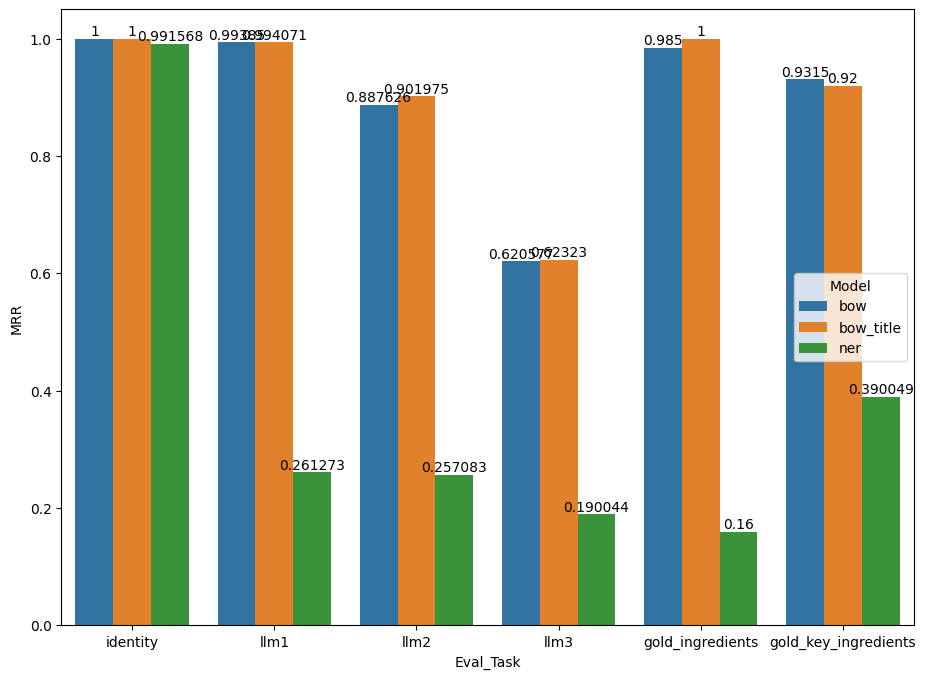

In [32]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='MRR', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

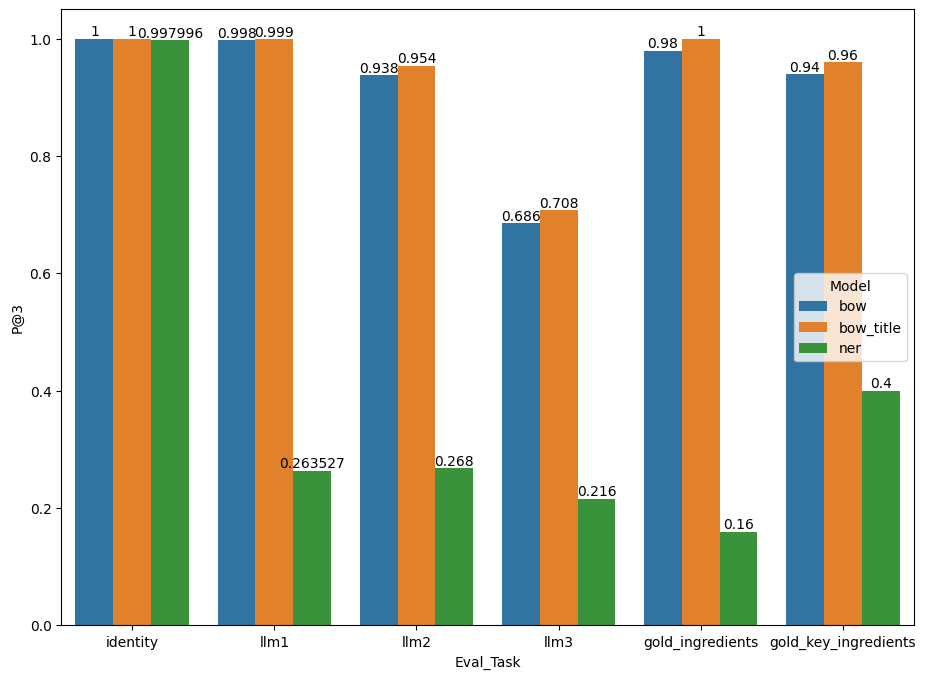

In [33]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='P@3', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

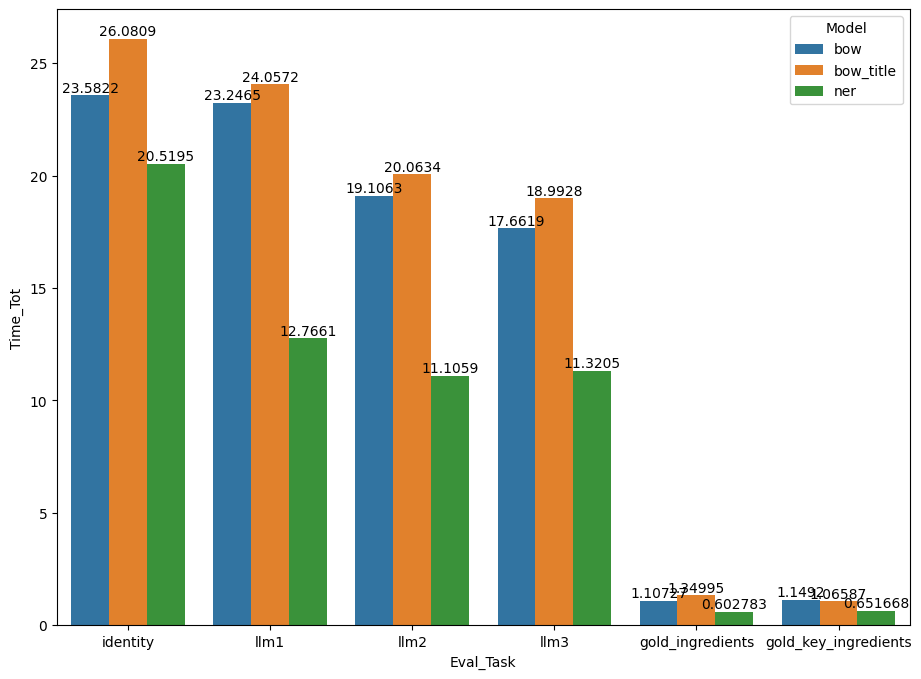

In [34]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='Time_Tot', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

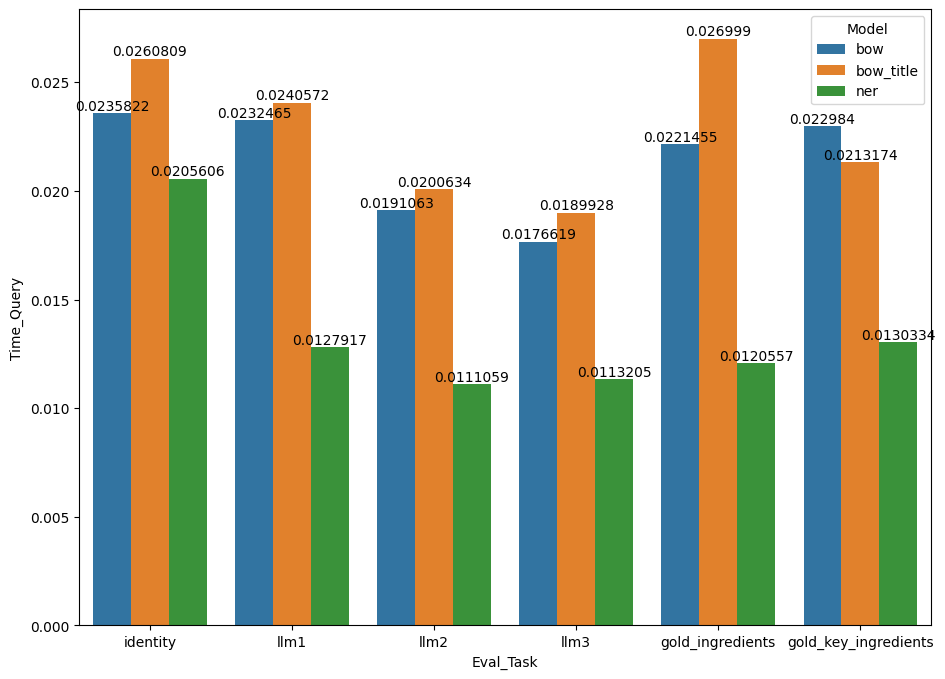

In [35]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='Time_Query', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

In [36]:
results_df

Model,Eval_Task,MRR,P@3,Time_Tot,Time_Query,Error_Count
str,str,f64,f64,f64,f64,i32
"""bow""","""identity""",1.0,1.0,23.58222,0.023582,0
"""bow""","""llm1""",0.99385,0.998,23.246475,0.023246,0
"""bow""","""llm2""",0.887626,0.938,19.106316,0.019106,0
"""bow""","""llm3""",0.620577,0.686,17.661919,0.017662,0
"""bow""","""gold_ingredients""",0.985,0.98,1.107274,0.022145,0
…,…,…,…,…,…,…
"""ner""","""llm1""",0.261273,0.263527,12.766094,0.012792,2
"""ner""","""llm2""",0.257083,0.268,11.105853,0.011106,0
"""ner""","""llm3""",0.190044,0.216,11.320489,0.01132,0


In [37]:
from datetime import datetime
date_time = datetime.now().strftime("%Y_%m_%d__%H_%M")

In [38]:
date_time

'2025_06_11__13_36'

In [39]:
#results_df.write_parquet(f"../../data/results/temp/{date_time}.parquet")

In [40]:
#pl.read_parquet(f"../../data/results/temp/{date_time}.parquet")